In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
import io
import os
import pyarrow.parquet as pq
import numpy as np

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Loading data

In [4]:
script_dir = os.path.dirname('__file__') #<-- absolute dir the script is in
rel_path = "s3_OTA_HotelAvailNotifRQ_files/"
abs_file_path = os.path.join(script_dir, rel_path)
dataset = pq.ParquetDataset(abs_file_path)
table = dataset.read()

In [5]:
avail_test = table.to_pandas()
avail_test

,HotelAvailNotifRQ_Messages
0,[{'MessageMeta': {'X-Correlation-ID': '3743806...
1,[{'MessageMeta': {'X-Correlation-ID': '33b84d2...
2,[{'MessageMeta': {'X-Correlation-ID': 'f33924a...
3,[{'MessageMeta': {'X-Correlation-ID': '2dea4f5...
4,[{'MessageMeta': {'X-Correlation-ID': 'e849704...
5,[{'MessageMeta': {'X-Correlation-ID': '4eaf5c6...
6,[{'MessageMeta': {'X-Correlation-ID': 'f2bff8e...
7,[{'MessageMeta': {'X-Correlation-ID': 'b678cf2...
8,[{'MessageMeta': {'X-Correlation-ID': '17b0f76...
9,[{'MessageMeta': {'X-Correlation-ID': '54a52d1...


In [6]:
avail_test.iloc[0]

HotelAvailNotifRQ_Messages    [{'MessageMeta': {'X-Correlation-ID': '3743806...
Name: 0, dtype: object

In [7]:
avail_test.iloc[0]["HotelAvailNotifRQ_Messages"]

array([{'MessageMeta': {'X-Correlation-ID': '3743806e-b50f-4ddf-ba70-d11ff41208b1', 'Type': 'OTA_HotelAvailNotifRQ', 'AppId': 'siteminder'}, 'OTA_HotelAvailNotifRQ': {'PrimaryLangID': None, 'EchoToken': '3743806e-b50f-4ddf-ba70-d11ff41208b1', 'TimeStamp': None, 'Version': None, 'Target': None, 'AvailStatusMessages': {'HotelCode': '964H', 'ChainCode': None, 'HotelName': None, 'AvailStatusMessage': array([{'BookingLimit': 7.0, 'StatusApplicationControl': {'InvTypeCode': '15784', 'RatePlanCode': 'ADV', 'Start': '2022-05-02', 'End': '2022-05-02', 'Mon': 'true', 'Tue': 'false', 'Weds': 'false', 'Thur': 'false', 'Fri': 'false', 'Sat': 'false', 'Sun': 'false'}, 'LengthsOfStay': None, 'RestrictionStatus': {'Restriction': 'Master', 'Status': 'Open', 'MinAdvancedBookingOffset': None, 'MaxAdvancedBookingOffset': None}, 'OriginalData': ''},
              {'BookingLimit': None, 'StatusApplicationControl': {'InvTypeCode': '15784', 'RatePlanCode': 'ADV', 'Start': '2022-05-02', 'End': '2022-05-02', 'M

# Splliting data

In [8]:
def explode_and_split(dataframe: pd.DataFrame, column: str):
    unnested = dataframe.explode(column)
    return pd.DataFrame(list(unnested[column]))

In [9]:
HotelAvailNotifRQ_Messages_splited = explode_and_split(avail_test, "HotelAvailNotifRQ_Messages")
HotelAvailNotifRQ_Messages_splited

,MessageMeta,OTA_HotelAvailNotifRQ
0,{'X-Correlation-ID': '3743806e-b50f-4ddf-ba70-...,"{'PrimaryLangID': None, 'EchoToken': '3743806e..."
1,{'X-Correlation-ID': 'd75c95ee-7ebc-4a53-a144-...,"{'PrimaryLangID': None, 'EchoToken': 'd75c95ee..."
2,{'X-Correlation-ID': 'fd167248-426f-49b3-860e-...,"{'PrimaryLangID': None, 'EchoToken': 'fd167248..."
3,{'X-Correlation-ID': 'eda1cc92-615b-4db1-b999-...,"{'PrimaryLangID': None, 'EchoToken': 'eda1cc92..."
4,{'X-Correlation-ID': '333e847e-4a31-4580-a689-...,"{'PrimaryLangID': None, 'EchoToken': '333e847e..."
...,...,...
20132,{'X-Correlation-ID': 'e36b8ded-ef61-4f0c-b28b-...,"{'PrimaryLangID': None, 'EchoToken': 'e36b8ded..."
20133,{'X-Correlation-ID': 'a9a40fc8-d23d-45d4-b540-...,"{'PrimaryLangID': None, 'EchoToken': 'a9a40fc8..."
20134,{'X-Correlation-ID': 'f8c1d9fe-66c0-4988-81a0-...,"{'PrimaryLangID': None, 'EchoToken': 'f8c1d9fe..."
20135,{'X-Correlation-ID': '79794d41-2427-4153-ae39-...,"{'PrimaryLangID': None, 'EchoToken': '79794d41..."


In [10]:
OTA_HotelAvailNotifRQ = pd.DataFrame(list(HotelAvailNotifRQ_Messages_splited["OTA_HotelAvailNotifRQ"]))
HotelAvailNotifRQ_Messages_splited = HotelAvailNotifRQ_Messages_splited.drop(columns=["OTA_HotelAvailNotifRQ"])
HotelAvailNotifRQ_Messages_splited = pd.DataFrame(list(HotelAvailNotifRQ_Messages_splited["MessageMeta"]))
HotelAvailNotifRQ_Messages_splited = HotelAvailNotifRQ_Messages_splited.merge(OTA_HotelAvailNotifRQ,  left_on="X-Correlation-ID", right_on='EchoToken')

In [11]:
def split_and_merge(dataframe: pd.DataFrame, column: str):
    splited = pd.DataFrame(list(dataframe[column]))
    merged = dataframe.merge(splited, left_index=True, right_index=True)
    return merged.drop(columns=[column])

In [12]:
HotelAvailNotifRQ_Messages_splited = split_and_merge(HotelAvailNotifRQ_Messages_splited, "AvailStatusMessages")

In [13]:
def explode_split_and_merge(dataframe: pd.DataFrame, column: str):
    unnested = dataframe.explode(column)
    splited = pd.DataFrame(list(unnested[column]))
    merged = splited.merge(unnested, left_index=True, right_index=True)
    return merged.drop(columns=[column])

In [14]:
HotelAvailNotifRQ_Messages_splited = explode_split_and_merge(HotelAvailNotifRQ_Messages_splited, "AvailStatusMessage")

In [15]:
HotelAvailNotifRQ_Messages_splited = split_and_merge(HotelAvailNotifRQ_Messages_splited, "StatusApplicationControl")

In [16]:
LengthsOfStay_no_none = []
for v in HotelAvailNotifRQ_Messages_splited["LengthsOfStay"]:
    if v is not None:
        LengthsOfStay_no_none.append(v)
    else:
        LengthsOfStay_no_none.append({'LengthOfStay': np.array([{'MinMaxMessageType': None, 'Time': None, 'TimeUnit': None, 'MinLOS': None, 'MaxLOS': None},
         {'MinMaxMessageType': None, 'Time': None, 'TimeUnit': None, 'MinLOS': None, 'MaxLOS': None}],
        dtype=object)})

In [17]:
LengthsOfStay_no_none = pd.DataFrame(LengthsOfStay_no_none)
HotelAvailNotifRQ_Messages_splited = HotelAvailNotifRQ_Messages_splited.merge(LengthsOfStay_no_none, left_index=True, right_index=True)
HotelAvailNotifRQ_Messages_splited = HotelAvailNotifRQ_Messages_splited.drop(columns=["LengthsOfStay"])

In [18]:
HotelAvailNotifRQ_Messages_splited = explode_split_and_merge(HotelAvailNotifRQ_Messages_splited, "LengthOfStay")

In [19]:
RestrictionStatus_no_none = []
for v in HotelAvailNotifRQ_Messages_splited["RestrictionStatus"]:
    if v is not None:
        RestrictionStatus_no_none.append(v)
    else:
        RestrictionStatus_no_none.append({'Restriction': None, 'Status': None, 'MinAdvancedBookingOffset': None, 'MaxAdvancedBookingOffset': None})

In [20]:
RestrictionStatus_splited = pd.DataFrame(RestrictionStatus_no_none)
HotelAvailNotifRQ_Messages_splited = HotelAvailNotifRQ_Messages_splited.merge(RestrictionStatus_splited, left_index=True, right_index=True)
HotelAvailNotifRQ_Messages_splited = HotelAvailNotifRQ_Messages_splited.drop(columns=["RestrictionStatus"])
HotelAvailNotifRQ_Messages_splited

,MinMaxMessageType,Time,TimeUnit,MinLOS,MaxLOS,BookingLimit,OriginalData,X-Correlation-ID,Type,AppId,PrimaryLangID,EchoToken,TimeStamp,Version,Target,HotelCode,ChainCode,HotelName,InvTypeCode,RatePlanCode,Start,End,Mon,Tue,Weds,Thur,Fri,Sat,Sun,Restriction,Status,MinAdvancedBookingOffset,MaxAdvancedBookingOffset
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,None,None,None,None,None,NaN,,71e8b302-4937-4765-ab74-bad57005008b,OTA_HotelAvailNotifRQ,siteminder,None,71e8b302-4937-4765-ab74-bad57005008b,None,None,None,6IL,None,None,15777,NRF,2022-08-25,2022-08-25,false,false,false,true,false,false,false,Departure,Open,None,None
20101,None,None,None,None,None,NaN,,71e8b302-4937-4765-ab74-bad57005008b,OTA_HotelAvailNotifRQ,siteminder,None,71e8b302-4937-4765-ab74-bad57005008b,None,None,None,6IL,None,None,15777,NRF,2022-08-25,2022-08-25,false,false,false,true,false,false,false,Departure,Open,None,None
20101,None,None,None,None,None,NaN,,71e8b302-4937-4765-ab74-bad57005008b,OTA_HotelAvailNotifRQ,siteminder,None,71e8b302-4937-4765-ab74-bad57005008b,None,None,None,6IL,None,None,15777,NRF,2022-08-25,2022-08-25,false,false,false,true,false,false,false,Departure,Open,None,None
20101,None,None,None,None,None,NaN,,71e8b302-4937-4765-ab74-bad57005008b,OTA_HotelAvailNotifRQ,siteminder,None,71e8b302-4937-4765-ab74-bad57005008b,None,None,None,6IL,None,None,15777,NRF,2022-08-25,2022-08-25,false,false,false,true,false,false,false,Departure,Open,None,None


# Data analysis

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [22]:
HotelAvailNotifRQ_Messages_splited['AppId'].value_counts()

siteminder    589328
Name: AppId, dtype: int64

In [23]:
HotelAvailNotifRQ_Messages_splited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589328 entries, 0 to 20101
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   MinMaxMessageType         176088 non-null  object 
 1   Time                      176088 non-null  object 
 2   TimeUnit                  0 non-null       object 
 3   MinLOS                    0 non-null       object 
 4   MaxLOS                    0 non-null       object 
 5   BookingLimit              137576 non-null  float64
 6   OriginalData              589328 non-null  object 
 7   X-Correlation-ID          589328 non-null  object 
 8   Type                      589328 non-null  object 
 9   AppId                     589328 non-null  object 
 10  PrimaryLangID             0 non-null       object 
 11  EchoToken                 589328 non-null  object 
 12  TimeStamp                 0 non-null       object 
 13  Version                   0 non-null       ob

In [24]:
font = {'family' : 'sans serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

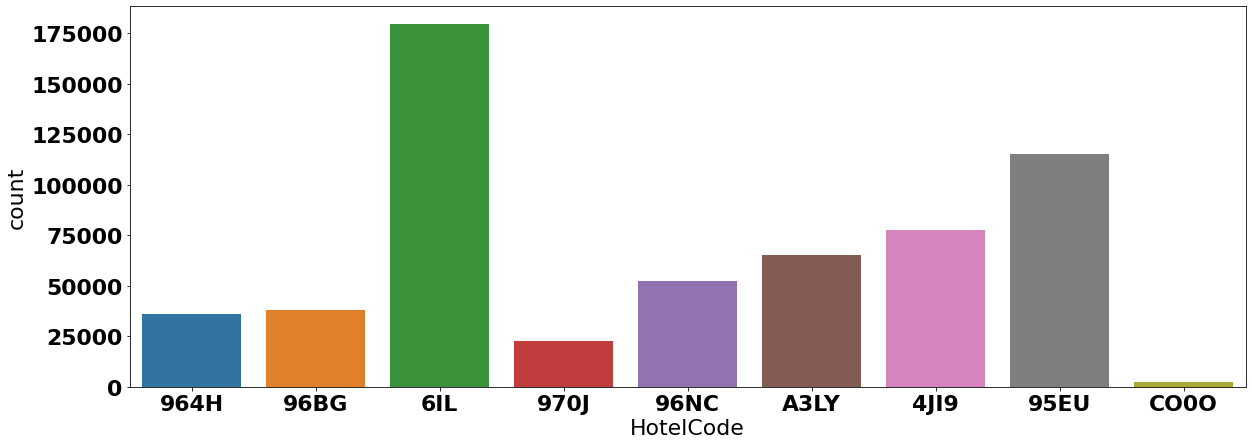

In [25]:
countplt, ax = plt.subplots(figsize = (20,7))
ax = sns.countplot(x="HotelCode", data=HotelAvailNotifRQ_Messages_splited)
# ax = ax.set_xticks(np.arange(1.0, max_BookingLimit, 5))

In [26]:
HotelAvailNotifRQ_Messages_splited["BookingLimit"].isnull().sum()

451752

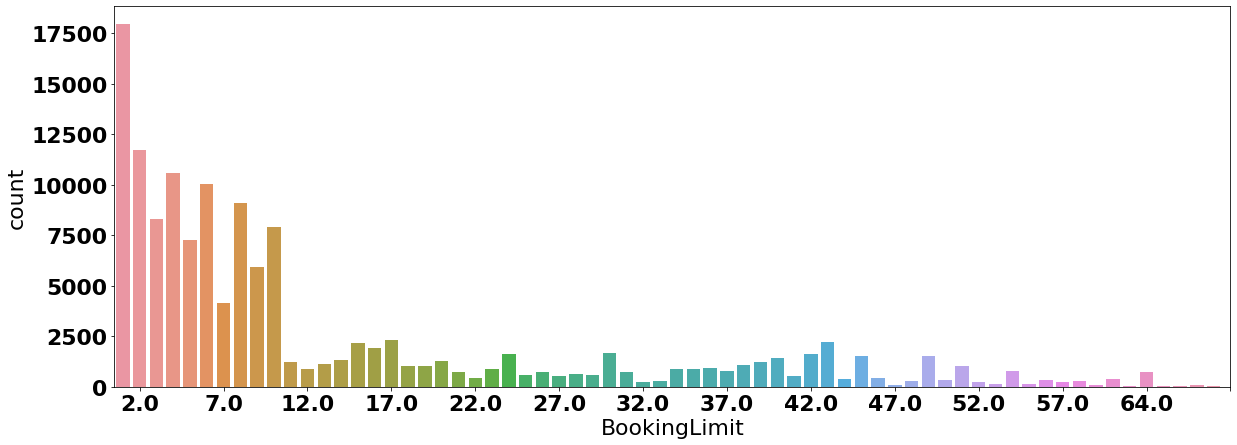

In [27]:
max_BookingLimit = max(HotelAvailNotifRQ_Messages_splited["BookingLimit"])
countplt, ax = plt.subplots(figsize = (20,7))
ax = sns.countplot(x="BookingLimit", data=HotelAvailNotifRQ_Messages_splited)
ax = ax.set_xticks(np.arange(1.0, max_BookingLimit, 5))

In [28]:
HotelAvailNotifRQ_Messages_splited["BookingLimit"].isnull().sum()

451752

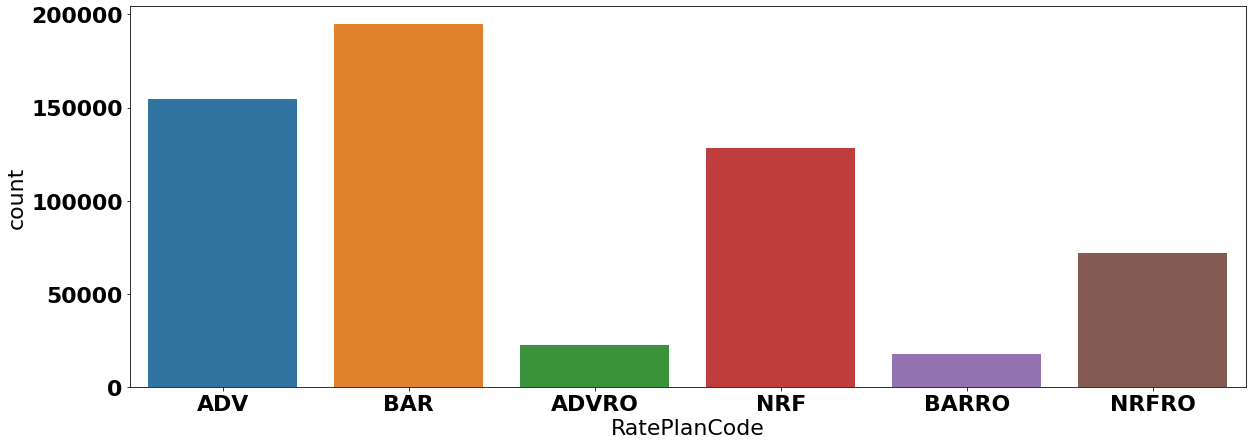

In [29]:
countplt, ax = plt.subplots(figsize = (20,7))
ax = sns.countplot(x="RatePlanCode", data=HotelAvailNotifRQ_Messages_splited)

In [30]:
HotelAvailNotifRQ_Messages_splited["RatePlanCode"].isnull().sum()

0

### StatusApplicationControl

In [31]:
HotelAvailNotifRQ_Messages_splited["Start"] = pd.to_datetime(HotelAvailNotifRQ_Messages_splited["Start"], format='%Y-%m-%d')
HotelAvailNotifRQ_Messages_splited["Start"]

0       2022-05-02
0       2022-05-02
0       2022-05-02
0       2022-05-02
0       2022-05-02
           ...    
20101   2022-08-25
20101   2022-08-25
20101   2022-08-25
20101   2022-08-25
20101   2022-08-25
Name: Start, Length: 589328, dtype: datetime64[ns]

In [32]:
HotelAvailNotifRQ_Messages_splited["End"] = pd.to_datetime(HotelAvailNotifRQ_Messages_splited["Start"], format='%Y-%m-%d')

In [33]:
StatusApplicationControl_Start = pd.DataFrame()
StatusApplicationControl_Start["year"] = HotelAvailNotifRQ_Messages_splited["Start"].dt.year
StatusApplicationControl_Start["month"] = HotelAvailNotifRQ_Messages_splited["Start"].dt.month
StatusApplicationControl_Start["year"].value_counts()

2021    351408
2022    237920
Name: year, dtype: int64

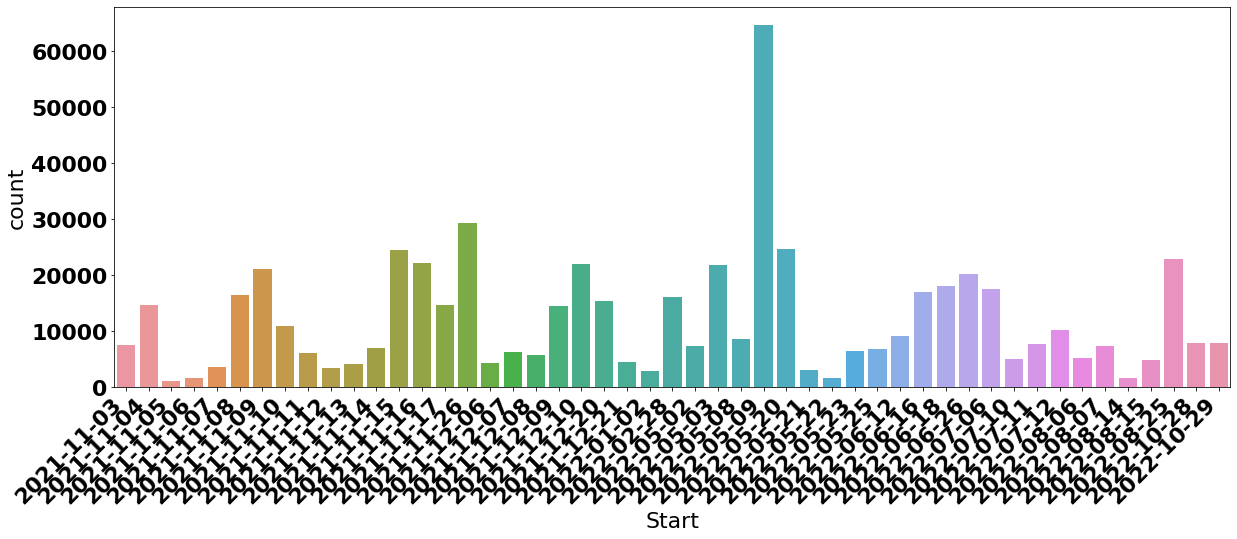

In [34]:
fig, ax = plt.subplots(figsize = (20,7))
fig = sns.countplot(x = "Start", data = HotelAvailNotifRQ_Messages_splited)
x_dates = HotelAvailNotifRQ_Messages_splited['Start'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax = ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

In [35]:
HotelAvailNotifRQ_Messages_splited['Difference'] = (HotelAvailNotifRQ_Messages_splited['Start'] - HotelAvailNotifRQ_Messages_splited['End']).dt.days + 1
HotelAvailNotifRQ_Messages_splited["Difference"].value_counts()

1    589328
Name: Difference, dtype: int64

In [36]:
def label_day(row):
   if row["Mon"] == "true":
      return "Mon"
   if row["Tue"] == "true":
      return "Tue"
   if row["Weds"] == "true":
      return "Weds"
   if row["Thur"] == "true":
      return "Thur"
   if row["Fri"] == "true":
      return "Fri"
   if row["Sat"] == "true":
      return "Sat"
   return 'Sun'

In [37]:
HotelAvailNotifRQ_Messages_splited["Day_of_week"] = HotelAvailNotifRQ_Messages_splited.apply(lambda row: label_day(row), axis=1)
HotelAvailNotifRQ_Messages_splited

,MinMaxMessageType,Time,TimeUnit,MinLOS,MaxLOS,BookingLimit,OriginalData,X-Correlation-ID,Type,AppId,PrimaryLangID,EchoToken,TimeStamp,Version,Target,HotelCode,ChainCode,HotelName,InvTypeCode,RatePlanCode,Start,End,Mon,Tue,Weds,Thur,Fri,Sat,Sun,Restriction,Status,MinAdvancedBookingOffset,MaxAdvancedBookingOffset,Difference,Day_of_week
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None,1,Mon
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None,1,Mon
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None,1,Mon
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None,1,Mon
0,None,None,None,None,None,7.0,,3743806e-b50f-4ddf-ba70-d11ff41208b1,OTA_HotelAvailNotifRQ,siteminder,None,3743806e-b50f-4ddf-ba70-d11ff41208b1,None,None,None,964H,None,None,15784,ADV,2022-05-02,2022-05-02,true,false,false,false,false,false,false,Master,Open,None,None,1,Mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,None,None,None,None,None,NaN,,71e8b302-4937-4765-ab74-bad57005008b,OTA_HotelAvailNotifRQ,siteminder,None,71e8b302-4937-4765-ab74-bad57005008b,None,None,None,6IL,None,None,15777,NRF,2022-08-25,2022-08-25,false,false,false,true,false,false,false,Departure,Open,None,None,1,Thur
20101,None,None,None,None,None,NaN,,71e8b302-4937-4765-ab74-bad57005008b,OTA_HotelAvailNotifRQ,siteminder,None,71e8b302-4937-4765-ab74-bad57005008b,None,None,None,6IL,None,None,15777,NRF,2022-08-25,2022-08-25,false,false,false,true,false,false,false,Departure,Open,None,None,1,Thur
20101,None,None,None,None,None,NaN,,71e8b302-4937-4765-ab74-bad57005008b,OTA_HotelAvailNotifRQ,siteminder,None,71e8b302-4937-4765-ab74-bad57005008b,None,None,None,6IL,None,None,15777,NRF,2022-08-25,2022-08-25,false,false,false,true,false,false,false,Departure,Open,None,None,1,Thur
20101,None,None,None,None,None,NaN,,71e8b302-4937-4765-ab74-bad57005008b,OTA_HotelAvailNotifRQ,siteminder,None,71e8b302-4937-4765-ab74-bad57005008b,None,None,None,6IL,None,None,15777,NRF,2022-08-25,2022-08-25,false,false,false,true,false,false,false,Departure,Open,None,None,1,Thur


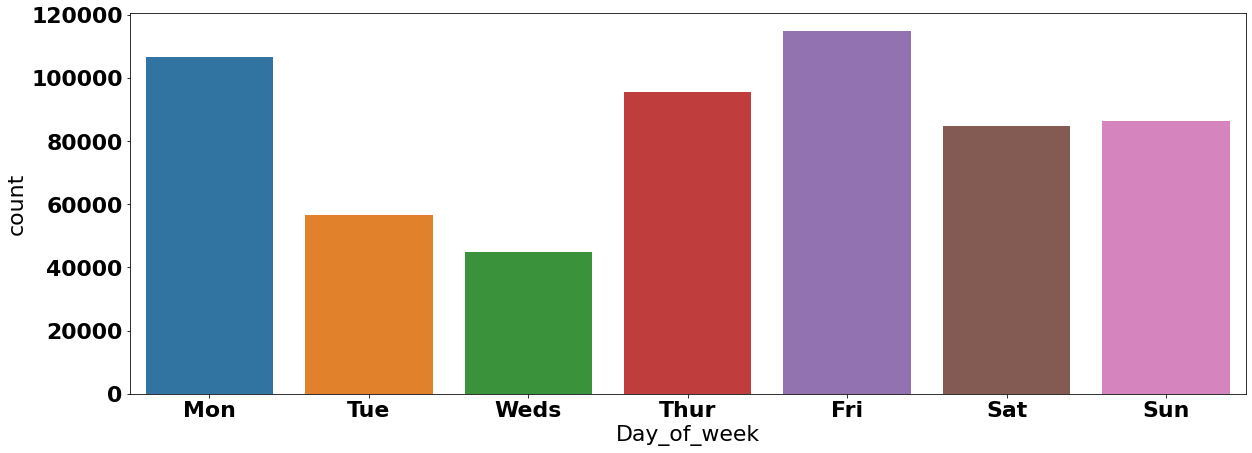

In [38]:
countplt, ax = plt.subplots(figsize = (20,7))
ax = sns.countplot(x = "Day_of_week", data=HotelAvailNotifRQ_Messages_splited,
                  order=["Mon", "Tue", "Weds", "Thur", "Fri", "Sat", "Sun"])

### Restriction

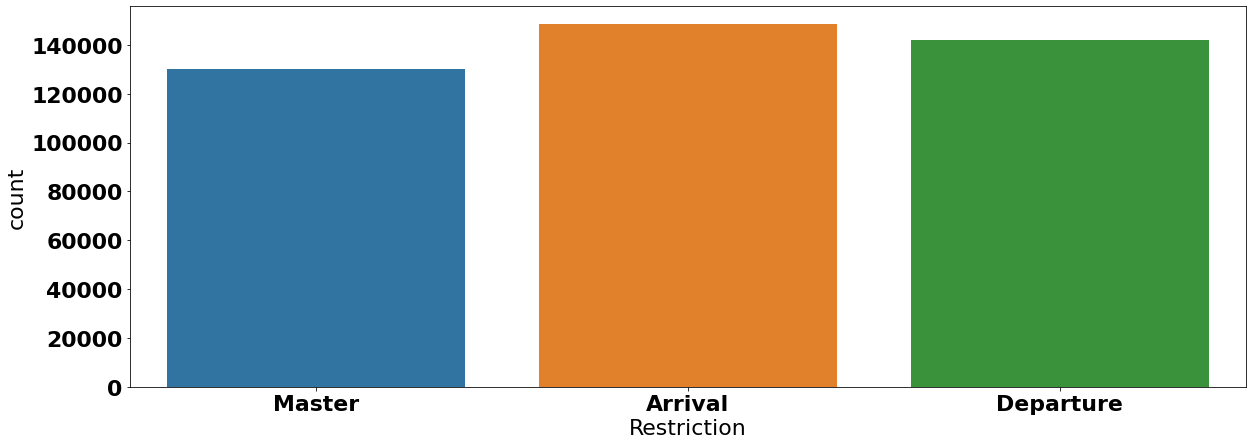

In [39]:
countplt, ax = plt.subplots(figsize = (20,7))
ax = sns.countplot(x = "Restriction", data=HotelAvailNotifRQ_Messages_splited)